*Python Modules*

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
data_dir = '../input/data-chamber/DATA_CHAMBER_2021/'
TRAIN = 'train'
TEST = 'test'
VAL = 'val'
# VGG-16 Takes 224x224 images as input, so we resize all of them

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.Grayscale(3),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomAutocontrast(),
        #transforms.RandomAdjustSharpness(),
        transforms.ToTensor()]),
    TEST: transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: ImageFolderWithPaths(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN,TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}
pathloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x].imgs, batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, TEST]
}
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN,  TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 6717 images under train
Loaded 1607 images under test
Classes: 
['2C', '3C', '4C']


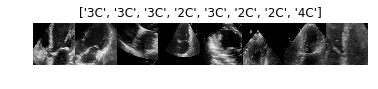

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes,_ = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [5]:
torch.__version__

'0.3.1b0+2b47480'

In [6]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels,_ = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

# Evaluate func

This helper function will give us the accuracy of our model on the test set.

In [7]:

def eval_model(vgg, criterion):
    y_true = []
    y_pred = []
    vid_id = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels, fname = data
        for f in fname:
            vid_id.append(f.split('/')[-1].split('.')[0].split('_')[0])
        y_true = y_true + labels.tolist()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.data[0]
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return y_true,y_pred,vid_id

In [8]:
vgg16 = models.vgg19_bn()
vgg16.load_state_dict(torch.load("../input/vgg19bn/vgg19_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

1000


The output above is the summary of our model. Notice how the last layer has 4 output features as we specified. 

In [9]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
    print("Loaded!")

In [10]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)

Let's see how our model performs before any training

In [11]:
print("Test before training")
eval_model(vgg16, criterion)
print('')

Test before training
Evaluating model
----------
Test batch 200/201
Evaluation completed in 0m 22s
Avg loss (test): 0.1439
Avg acc (test): 0.2738
----------



Ground truth:


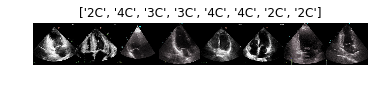

Prediction:


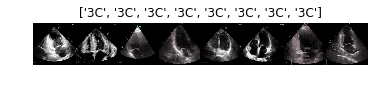

In [12]:
visualize_model(vgg16) #test before training

Not really great results. Let's see if it can do better after training 

## Training



For every epoch we iterate over all the training batches, compute the loss , and adjust the network weights with `loss.backward()` and `optimizer.step()`. 
Then we evaluate the performance over the validaton set. At the end of every epoch we print the network progress (loss and accuracy). 
The accuracy will tell us how many predictions were correct.

As we said before, transfer learning can work on smaller dataset too, so for every epoch we only iterate over half the trainig dataset (worth noting that it won't exactly be half of it over the entire training, as the data is shuffled, but it will almost certainly be a subset) 

In [13]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    #val_batches = len(dataloaders[VAL])
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
#         acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            
            print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                
            
                
            inputs, labels,_= data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes[TRAIN]
        avg_acc = acc_train  / dataset_sizes[TRAIN]
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)
        vgg.train(False)
        vgg.eval()
            

        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg,acc_values,loss_values

In [14]:
vgg16,acc,loss = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(),'VGG19_echocardiogram.pt')

Epoch 0/10
----------
Training batch 840/840

Epoch 0 result: 
Avg loss (train): 0.0762
Avg acc (train): 0.7212
----------

Epoch 1/10
----------
Training batch 840/840

Epoch 1 result: 
Avg loss (train): 0.0399
Avg acc (train): 0.8682
----------

Epoch 2/10
----------
Training batch 840/840

Epoch 2 result: 
Avg loss (train): 0.0311
Avg acc (train): 0.8977
----------

Epoch 3/10
----------
Training batch 840/840

Epoch 3 result: 
Avg loss (train): 0.0255
Avg acc (train): 0.9171
----------

Epoch 4/10
----------
Training batch 840/840

Epoch 4 result: 
Avg loss (train): 0.0244
Avg acc (train): 0.9202
----------

Epoch 5/10
----------
Training batch 840/840

Epoch 5 result: 
Avg loss (train): 0.0215
Avg acc (train): 0.9299
----------

Epoch 6/10
----------
Training batch 840/840

Epoch 6 result: 
Avg loss (train): 0.0196
Avg acc (train): 0.9363
----------

Epoch 7/10
----------
Training batch 840/840

Epoch 7 result: 
Avg loss (train): 0.0188
Avg acc (train): 0.9372
----------

Epoch 8/

## Model evaluation and visualization (after training)

Let's evaluate our model again after 10 epochs of training

In [15]:
y_true,y_pred,vid_code = eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 200/201
Evaluation completed in 0m 17s
Avg loss (test): 0.0660
Avg acc (test): 0.9060
----------


In [16]:
print(len(y_true)) 
print(len(y_pred))

1607
1607


# Visualize our model ._.

Ground truth:


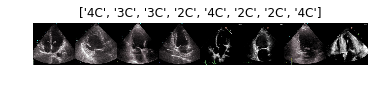

Prediction:


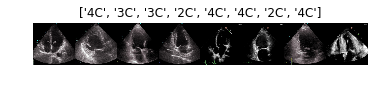

Ground truth:


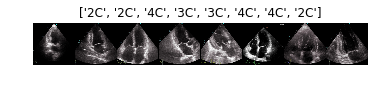

Prediction:


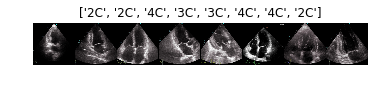

Ground truth:


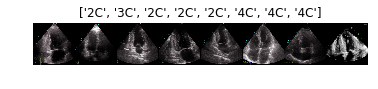

Prediction:


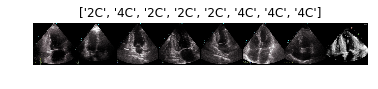

Ground truth:


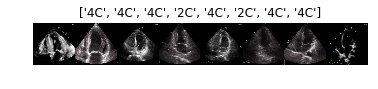

Prediction:


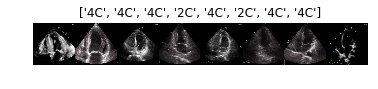

In [17]:
visualize_model(vgg16, num_images=32)

In [18]:
from sklearn.metrics import accuracy_score,classification_report
#print(accuracy_score(y_true,y_pred))

The accuracy score seem to be good 

Hope you found this useful! 

# Let check out our test data


In [19]:
import pandas as pd
import glob


df = pd.DataFrame(list(zip(y_true,y_pred,vid_code)),columns =['y_true','y_pred','vid_id'])
df.to_csv('df.csv',encoding='utf-8',index=False)

In [20]:
df.head(10)

,y_true,y_pred,vid_id
0,1,2,174
1,2,2,184
2,2,2,167
3,2,2,180
4,2,2,193
5,1,1,162
6,2,2,182
7,0,0,178
8,0,0,165
9,2,1,195


In [21]:
from statistics import mode
vid_list = list(set(df['vid_id'].values))
#df.groupby(['vid_id'])


In [22]:
print(vid_list)

['179', '191', '167', '158', '170', '157', '185', '194', '160', '168', '193', '192', '180', '183', '176', '188', '166', '159', '169', '189', '161', '171', '187', '174', '181', '162', '182', '178', '172', '164', '184', '190', '165', '195', '163', '177', '186', '173', '175']


In [23]:
y_true = []
y_pred = []
for vid in vid_list:
    #print(vid)
    tmp_df = df[df['vid_id']==vid]
    #print(len(tmp_df))
    vid_pred = tmp_df['y_pred'].mode().values[0]
    vid_label = tmp_df['y_true'].mode().values[0]
    y_true.append(vid_label)
    y_pred.append(vid_pred)
    #print(vid_label,"\n",vid_pred)
    
    #print('vid: {} label: {} pred: {}'.format(vid,vid_label,vid_pred))

In [24]:
accuracy_score(y_true,y_pred)

0.9230769230769231

In [25]:
def plot_history(history,loss,acc): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(loss, 'r', label="training loss")
    ax1.grid(True)
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('loss', color='r')
    ax1.legend(loc="best", fontsize=9)    
    ax1.tick_params('y', colors='r')

    ax2 = ax1.twinx()
    ax2.plot(acc, 'b', label="training acc")
    ax2.legend(loc="lower right", fontsize=9)
    ax2.set_ylabel('acc', color='b')        
    ax2.tick_params('y', colors='b')

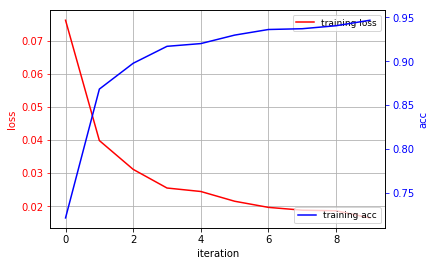

In [26]:
plot_history(vgg16,loss,acc)